# DMRG: Matrix Product States(MPS) Version
Edited by [Song Menghan](https://quantummc.xyz/members/menghan-song/), Aug.2022.

This is a notebook which breifly shows the MPS version of DMRG after being familiar with the [traditional algorithm](https://colab.research.google.com/github/hylu666/hku-physics4150/blob/main/DMRG_tutorial/DMRG_blockEnlarge.ipynb) with block enlargement. The notes are typed based on the review of Prof. Schollwöck [arXiv:1008.3477](https://arxiv.org/abs/1008.3477v2). The example codes below are adapted from a powerful website [Tensor.net](https://www.tensors.net/p-dmrg).

### MPS
In this version, the quantum many body wavefunction of a length $L$ chain is written as a big tensor $c_{\sigma_1,...,\sigma_L}$ with $L$ indices. Each indices can hold $d$ values, where $d$ corresponding to the local degree of freedom of a site, $d=2$ for spin-1/2 chains. Tensor $c_{\sigma_1,...,\sigma_L}$ can be decomposed into a product of a tensor string (tensor network) by singular value decompositions. 
$$
\left | \Psi  \right \rangle =\sum_{\sigma_{1},...,\sigma_{L}}^{} c_{\sigma_1,...,\sigma_L}\left | \sigma_1,...,\sigma_L  \right \rangle 
$$

$$
\Downarrow {SVD} 
$$

$$
c_{\sigma_1,...,\sigma_L}=\sum_{a_1,...,a_{L-1}}^{}\Gamma_{a1}^{\sigma_1}\Gamma_{a_1, a_2}^{\sigma_2}...\Gamma_{a_{L-1}}^{\sigma_L}
\equiv \Gamma^{\sigma_1}...\Gamma^{\sigma_{L-1}}\Gamma^{\sigma_{L}}
$$

For a given spin configuration of the chain, the tensor $c_{\sigma_{1}...\sigma_{L}}$ is just a number(may be complex) representing the amplitude of that spin configuration in a certain state. And, the tensor network $\Gamma...\Gamma$ becomes a consecutive matrix product (matrix is just a tensor of 2 indices). The dimensions of these $\Gamma$ matrices may maximally be $(1\times d), (d\times d^{2}),..., (d^{L/2-1}\times d^{L/2}),(d^{L/2}\times d^{L/2-1}),...,(d^{2}\times d), (d\times 1)$, going from the first to the last site(assume L even). Here we still experience the exponential growth of data, therefore, we need a truncation process similar to the traditional DMRG.

### Truncation
Here I will demonstrate the basic picture of truncating the MPS by SVD. Given a wavefunction $\left | \psi  \right \rangle =\sum_{j}^{}\left | \psi_j  \right \rangle_{L}\left | \psi_j  \right \rangle_{R}$, where we divide it into left and right block. Or in the MPS form:
$$
\left | \psi  \right \rangle = \sum_{j}^{} \Gamma^{L}_{\sigma_1,...,\sigma_i;j}\Gamma^{R}_{j\sigma_i,...,\sigma_L}\left | \sigma_1...\sigma_i  \right \rangle_{L}\left | \sigma_i...\sigma_L\right \rangle_{R}
$$
Now we reshape the tensor $\Gamma^{L}_{\sigma_1,...,\sigma_i;j}\Gamma^{R}_{j\sigma_i,...,\sigma_L}$ into a matrix and do SVD on it.

$$
\begin{align*}
\left | \psi  \right \rangle &= \sum_{\alpha,j}^{} U_{\sigma_{1...i}\ ,\alpha}\ S_{\alpha,j}V^{\dagger}_{j,\sigma_{i...L}}\ \left | \sigma_1...\sigma_i  \right \rangle_{L}\left | \sigma_i...\sigma_L\right \rangle_{R} \\
&= \sum_{j}^{}\lambda_j \left | \tilde{{\psi_{j}}}     \right \rangle_{L}\left | \tilde{{\psi_{j}}}     \right \rangle_{R},
\end{align*}
$$
where $\left | \tilde{{\psi_{j}}} \right \rangle_{L}=U_{\sigma_{...},\alpha}\left |\sigma_{1,...,i}\right \rangle_{L}$, $\left | \tilde{{\psi_{j}}} \right \rangle_{R}=V^{\dagger}_{j,\sigma_{...}}\left |\sigma_{i,...,L}\right \rangle_{R}$ and $S_{ij}=\lambda_i \delta_{ij}$

This is actually the Schmidt decomposition. Generally speaking, the bond dimension of $\alpha$ and $j$ are exponentially large. In the truncation, we need to keep the dimension fixed to $D$ and discard the rest,
$$
USV\to \tilde{U} \tilde{S} \tilde{V} 
$$
During the truncation, we aims to keep as much information of $\left | \psi  \right \rangle$ as possible. One optimal choice is:
$$
Max{|\left \langle \psi  | \tilde{\psi}\right \rangle |}=Max{\sum_{i<D}\lambda_i\tilde{\lambda_i}},
$$
which is to keep $D$ biggest Schmidt values after SVD.

Actually, the Schmidt decomposition reaveals the information of the reduced density matrix, $\rho_A=\sum_{a=1}^{r}s_{a}^{2}\left | a \right \rangle_{A}   \left \langle a \right |_{B}$, where $r$ is the rank. Thus, we truncate based on the Schmidt value here is equivalent to truncation based on the reduced density matrix's eigenvector in traditional DMRG.

### Algorithm
Outline the algorithm of the sample code below.
1. Randomly generate an MPS and we normalize the MPS to the left canonical form via SVD. During normalization, we construct the Hamiltonion in matrix product form.
2. Sweep from right to left and do the two-site update, in which we optimize the two site wavefunction (tensors) by minimizing $E=\frac{\left \langle \psi \right | H_{A\bullet \bullet B}\ \ \ \left | \psi  \right \rangle }{\left \langle \psi  | \psi  \right \rangle } $. This is done by the Lanczos method.
3. With the updated tensors, we do truncation, making the inner bond dimension upper bonded to $D$.
4. After sweeping to the left edge, start sweeping from left to right and do the two-site update as in step 2&3.
5. Keep sweeping untill converge.

In [ ]:
import numpy as np
from typing import List, Union, Tuple, Optional
from numpy import linalg as LA
import matplotlib.pyplot as plt

In [ ]:
  
# ncon network contractor
# by Glen Evenbly (c) for www.tensors.net, (v1.2) - last modified 6/2020


def ncon(tensors: List[np.ndarray],
         connects: List[Union[List[int], Tuple[int]]],
         con_order: Optional[Union[List[int], str]] = None,
         check_network: Optional[bool] = True,
         which_env: Optional[int] = 0):
    """
    Network CONtractor: contracts a tensor network of N tensors via a sequence
    of (N-1) tensordot operations. More detailed instructions and examples can
    be found at: https://arxiv.org/abs/1402.0939.
    Args:
    tensors: list of the tensors in the network.
    connects: length-N list of lists (or tuples) specifying the network
      connections. The jth entry of the ith list in connects labels the edge
      connected to the jth index of the ith tensor. Labels should be positive
      integers for internal indices and negative integers for free indices.
    con_order: optional argument to specify the order for contracting the
      positive indices. Defaults to ascending order if omitted. Can also be
      set at "greedy" or "full" to call a solver to automatically determine
      the order.
    check_network: if true then the input network is checked for consistency;
      this can catch many common user mistakes for defining networks.
    which_env: if provided, ncon will produce the environment of the requested
      tensor (i.e. the network given by removing the specified tensor from
      the original network). Only valid for networks with no open indices.
    Returns:
    Union[np.ndarray,float]: the result of the network contraction; an
      np.ndarray if the network contained open indices, otherwise a scalar.
    """
    num_tensors = len(tensors)
    tensor_list = [tensors[ele] for ele in range(num_tensors)]
    connect_list = [np.array(connects[ele]) for ele in range(num_tensors)]

    # generate contraction order if necessary
    flat_connect = np.concatenate(connect_list)
    if con_order is None:
        con_order = np.unique(flat_connect[flat_connect > 0])
    else:
        con_order = np.array(con_order)

    # check inputs if enabled
    if check_network:
        dims_list = [list(tensor.shape) for tensor in tensor_list]
        check_inputs(connect_list, flat_connect, dims_list, con_order)

    # do all partial traces
    for ele in range(len(tensor_list)):
        num_cont = len(connect_list[ele]) - len(np.unique(connect_list[ele]))
        if num_cont > 0:
            tensor_list[ele], connect_list[ele], cont_ind = partial_trace(
              tensor_list[ele], connect_list[ele])
            con_order = np.delete(
              con_order,
              np.intersect1d(con_order, cont_ind, return_indices=True)[1])

    # do all binary contractions
    while len(con_order) > 0:
    # identify tensors to be contracted
        cont_ind = con_order[0]
        locs = [
            ele for ele in range(len(connect_list))
            if sum(connect_list[ele] == cont_ind) > 0
        ]

        # do binary contraction
        cont_many, A_cont, B_cont = np.intersect1d(
            connect_list[locs[0]],
            connect_list[locs[1]],
            assume_unique=True,
            return_indices=True)
        if np.size(tensor_list[locs[0]]) < np.size(tensor_list[locs[1]]):
            ind_order = np.argsort(A_cont)
        else:
            ind_order = np.argsort(B_cont)

        tensor_list.append(
            np.tensordot(
                tensor_list[locs[0]],
                tensor_list[locs[1]],
                axes=(A_cont[ind_order], B_cont[ind_order])))
        connect_list.append(
            np.append(
                np.delete(connect_list[locs[0]], A_cont),
                np.delete(connect_list[locs[1]], B_cont)))

        # remove contracted tensors from list and update con_order
        del tensor_list[locs[1]]
        del tensor_list[locs[0]]
        del connect_list[locs[1]]
        del connect_list[locs[0]]
        con_order = np.delete(
            con_order,
            np.intersect1d(con_order, cont_many, return_indices=True)[1])

    # do all outer products
    while len(tensor_list) > 1:
        s1 = tensor_list[-2].shape
        s2 = tensor_list[-1].shape
        tensor_list[-2] = np.outer(tensor_list[-2].reshape(np.prod(s1)),
                                   tensor_list[-1].reshape(np.prod(s2))).reshape(
                                       np.append(s1, s2))
        connect_list[-2] = np.append(connect_list[-2], connect_list[-1])
        del tensor_list[-1]
        del connect_list[-1]

    # do final permutation
    if len(connect_list[0]) > 0:
        return np.transpose(tensor_list[0], np.argsort(-connect_list[0]))
    else:
        return tensor_list[0].item()


def partial_trace(A, A_label):
    """ Partial trace on tensor A over repeated labels in A_label """

    num_cont = len(A_label) - len(np.unique(A_label))
    if num_cont > 0:
        dup_list = []
        for ele in np.unique(A_label):
            if sum(A_label == ele) > 1:
                dup_list.append([np.where(A_label == ele)[0]])

        cont_ind = np.array(dup_list).reshape(2 * num_cont, order='F')
        free_ind = np.delete(np.arange(len(A_label)), cont_ind)

        cont_dim = np.prod(np.array(A.shape)[cont_ind[:num_cont]])
        free_dim = np.array(A.shape)[free_ind]

        B_label = np.delete(A_label, cont_ind)
        cont_label = np.unique(A_label[cont_ind])
        B = np.zeros(np.prod(free_dim))
        A = A.transpose(np.append(free_ind, cont_ind)).reshape(
            np.prod(free_dim), cont_dim, cont_dim)
        for ip in range(cont_dim):
            B = B + A[:, ip, ip]

        return B.reshape(free_dim), B_label, cont_label

    else:
        return A, A_label, []


def check_inputs(connect_list, flat_connect, dims_list, con_order):
    """ Check consistancy of NCON inputs"""

    pos_ind = flat_connect[flat_connect > 0]
    neg_ind = flat_connect[flat_connect < 0]

    # check that lengths of lists match
    if len(dims_list) != len(connect_list):
        raise ValueError(
            ('mismatch between %i tensors given but %i index sublists given') %
            (len(dims_list), len(connect_list)))

    # check that tensors have the right number of indices
    for ele in range(len(dims_list)):
        if len(dims_list[ele]) != len(connect_list[ele]):
            raise ValueError((
              'number of indices does not match number of labels on tensor %i: '
              '%i-indices versus %i-labels')
              % (ele, len(dims_list[ele]), len(connect_list[ele])))

    # check that contraction order is valid
    if not np.array_equal(np.sort(con_order), np.unique(pos_ind)):
        raise ValueError(('NCON error: invalid contraction order'))

    # check that negative indices are valid
    for ind in np.arange(-1, -len(neg_ind) - 1, -1):
        if sum(neg_ind == ind) == 0:
            raise ValueError(('NCON error: no index labelled %i') % (ind))
        elif sum(neg_ind == ind) > 1:
            raise ValueError(('NCON error: more than one index labelled %i') % (ind))

    # check that positive indices are valid and contracted tensor dimensions match
    flat_dims = np.array([item for sublist in dims_list for item in sublist])
    for ind in np.unique(pos_ind):
        if sum(pos_ind == ind) == 1:
            raise ValueError(('NCON error: only one index labelled %i') % (ind))
        elif sum(pos_ind == ind) > 2:
            raise ValueError(
              ('NCON error: more than two indices labelled %i') % (ind))

        cont_dims = flat_dims[flat_connect == ind]
        if cont_dims[0] != cont_dims[1]:
            raise ValueError(
              ('NCON error: tensor dimension mismatch on index labelled %i: '
               'dim-%i versus dim-%i') % (ind, cont_dims[0], cont_dims[1]))

    return True



In [ ]:

def doDMRG_MPO(A,ML,M,MR,chi, numsweeps = 10, dispon = 2, updateon = True, maxit = 2, krydim = 4):
    """
------------------------
by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 19/1/2019
------------------------
Implementation of DMRG for a 1D chain with open boundaries, using the \
two-site update strategy. Each update is accomplished using a custom \
implementation of the Lanczos iteration to find (an approximation to) the \
ground state of the superblock Hamiltonian. Input 'A' is containing the MPS \
tensors whose length is equal to that of the 1D lattice. The Hamiltonian is \
specified by an MPO with 'ML' and 'MR' the tensors at the left and right \
boundaries, and 'M' the bulk MPO tensor. Automatically grow the MPS bond \
dimension to maximum dimension 'chi'. Outputs 'A' and 'B' are arrays of the \
MPS tensors in left and right orthogonal form respectively, while 'sWeight' \
is an array of the Schmidt coefficients across different lattice positions. \
'Ekeep' is a vector describing the energy at each update step.

Optional arguments:
`numsweeps::Integer=10`: number of DMRG sweeps
`dispon::Integer=2`: print data never [0], after each sweep [1], each step [2]
`updateon::Bool=true`: enable or disable tensor updates
`maxit::Integer=2`: number of iterations of Lanczos method for each diagonalization
`krydim::Integer=4`: maximum dimension of Krylov space in superblock diagonalization
"""

    ##### left-to-right 'warmup', put MPS in right orthogonal form
    chid = M.shape[2] #local dimension
    Nsites = len(A)
    L = [0 for x in range(Nsites)]; L[0] = ML
    R = [0 for x in range(Nsites)]; R[Nsites-1] = MR
    for p in range(Nsites-1):
        chil = A[p].shape[0]; chir = A[p].shape[2]
        utemp, stemp, vhtemp = LA.svd(A[p].reshape(chil*chid,chir), full_matrices=False)
        A[p] = utemp.reshape(chil,chid,chir)
        A[p+1] = ncon([np.diag(stemp) @ vhtemp,A[p+1]], [[-1,1],[1,-2,-3]])/LA.norm(stemp)
        L[p+1] = ncon([L[p],M,A[p],np.conj(A[p])],[[2,1,4],[2,-1,3,5],[4,5,-3],[1,3,-2]])
    
    chil = A[Nsites-1].shape[0]; chir = A[Nsites-1].shape[2]
    utemp, stemp, vhtemp = LA.svd(A[Nsites-1].reshape(chil*chid,chir), full_matrices=False)
    A[Nsites-1] = utemp.reshape(chil,chid,chir)
    sWeight = [0 for x in range(Nsites+1)]
    sWeight[Nsites] = (np.diag(stemp) @ vhtemp) / LA.norm(stemp)
    
    Ekeep = np.array([])
    B = [0 for x in range(Nsites)]
    for k in range(1,numsweeps+2):
        
        ##### final sweep is only for orthogonalization (disable updates)
        if k == numsweeps+1:
            updateon = False
            dispon = 0
        
        ###### Optimization sweep: right-to-left
        for p in range(Nsites-2,-1,-1):
        
            ##### two-site update
            chil = A[p].shape[0]; chir = A[p+1].shape[2]
            psiGround = ncon([A[p],A[p+1],sWeight[p+2]],[[-1,-2,1],[1,-3,2],[2,-4]]).reshape(chil*chid*chid*chir)
            if updateon:
                psiGround, Entemp = eigLanczos(psiGround,doApplyMPO,(L[p],M,M,R[p+1]), maxit = maxit, krydim = krydim)
                Ekeep = np.append(Ekeep,Entemp)
            
            utemp, stemp, vhtemp = LA.svd(psiGround.reshape(chil*chid,chid*chir), full_matrices=False)
            chitemp = min(len(stemp),chi)
            A[p] = utemp[:,range(chitemp)].reshape(chil,chid,chitemp)
            sWeight[p+1] = np.diag(stemp[range(chitemp)]/LA.norm(stemp[range(chitemp)]))
            B[p+1] = vhtemp[range(chitemp),:].reshape(chitemp,chid,chir)
            
            ##### new block Hamiltonian
            R[p] = ncon([M,R[p+1],B[p+1],np.conj(B[p+1])],[[-1,2,3,5],[2,1,4],[-3,5,4],[-2,3,1]])
            
            if dispon == 2:
                print('Sweep: %d of %d, Loc: %d,Energy: %f' % (k, numsweeps, p, Ekeep[-1]))
        
        ###### left boundary tensor
        chil = A[0].shape[0]; chir = A[0].shape[2]
        Atemp = ncon([A[0],sWeight[1]],[[-1,-2,1],[1,-3]]).reshape(chil,chid*chir)
        utemp, stemp, vhtemp = LA.svd(Atemp, full_matrices=False)
        B[0] = vhtemp.reshape(chil,chid,chir)
        sWeight[0] = utemp @ (np.diag(stemp)/LA.norm(stemp))
        
        ###### Optimization sweep: left-to-right
        for p in range(Nsites-1):
        
            ##### two-site update
            chil = B[p].shape[0]; chir = B[p+1].shape[2]
            psiGround = ncon([sWeight[p],B[p],B[p+1]],[[-1,1],[1,-2,2],[2,-3,-4]]).reshape(chil*chid*chid*chir)
            if updateon:
                psiGround, Entemp = eigLanczos(psiGround,doApplyMPO,(L[p],M,M,R[p+1]), maxit = maxit, krydim = krydim)
                Ekeep = np.append(Ekeep,Entemp)
            
            utemp, stemp, vhtemp = LA.svd(psiGround.reshape(chil*chid,chid*chir), full_matrices=False)
            chitemp = min(len(stemp),chi)
            A[p] = utemp[:,range(chitemp)].reshape(chil,chid,chitemp)
            sWeight[p+1] = np.diag(stemp[range(chitemp)]/LA.norm(stemp[range(chitemp)]))
            B[p+1] = vhtemp[range(chitemp),:].reshape(chitemp,chid,chir)
            
            ##### new block Hamiltonian
            L[p+1] = ncon([L[p],M,A[p],np.conj(A[p])],[[2,1,4],[2,-1,3,5],[4,5,-3],[1,3,-2]])
        
            ##### display energy
            if dispon == 2:
                print('Sweep: %d of %d, Loc: %d,Energy: %f' % (k, numsweeps, p, Ekeep[-1]))
                
        ###### right boundary tensor
        chil = B[Nsites-1].shape[0]; chir = B[Nsites-1].shape[2]
        Atemp = ncon([B[Nsites-1],sWeight[Nsites-1]],[[1,-2,-3],[-1,1]]).reshape(chil*chid,chir)
        utemp, stemp, vhtemp = LA.svd(Atemp, full_matrices=False)
        A[Nsites-1] = utemp.reshape(chil,chid,chir)
        sWeight[Nsites] = (stemp/LA.norm(stemp))*vhtemp
        
        if dispon == 1:
            print('Sweep: %d of %d, Energy: %f, Bond dim: %d' % (k, numsweeps, Ekeep[-1], chi))
            
    return Ekeep, A, sWeight, B


#-------------------------------------------------------------------------
def doApplyMPO(psi,L,M1,M2,R):
    """ function for applying MPO to state """
    
    return ncon([psi.reshape(L.shape[2],M1.shape[3],M2.shape[3],R.shape[2]),L,M1,M2,R],
                       [[1,3,5,7],[2,-1,1],[2,4,-2,3],[4,6,-3,5],[6,-4,7]]).reshape( 
                               L.shape[2]*M1.shape[3]*M2.shape[3]*R.shape[2]);

#-------------------------------------------------------------------------
def eigLanczos(psivec,linFunct,functArgs, maxit = 2, krydim = 4):
    """ Lanczos method for finding smallest algebraic eigenvector of linear \
    operator defined as a function"""
    
    if LA.norm(psivec) == 0:
        psivec = np.random.rand(len(psivec))
    
    psi = np.zeros([len(psivec),krydim+1])
    A = np.zeros([krydim,krydim])
    dval = 0
    
    for ik in range(maxit):
        
        psi[:,0] = psivec/max(LA.norm(psivec),1e-16)
        for ip in range(1,krydim+1):
                
            psi[:,ip] = linFunct(psi[:,ip-1],*functArgs)
            
            for ig in range(ip):
                A[ip-1,ig] = np.dot(psi[:,ip],psi[:,ig])
                A[ig,ip-1] = np.conj(A[ip-1,ig])
            
            for ig in range(ip):
                psi[:,ip] = psi[:,ip] - np.dot(psi[:,ig],psi[:,ip])*psi[:,ig]
                psi[:,ip] = psi[:,ip] / max(LA.norm(psi[:,ip]),1e-16)
                    
        [dtemp,utemp] = LA.eigh(A)
        psivec = psi[:,range(0,krydim)] @ utemp[:,0]
        
    psivec = psivec/LA.norm(psivec)
    dval = dtemp[0]
    
    return psivec, dval



Sweep: 1 of 4, Energy: -12.053347, Bond dim: 16
Sweep: 2 of 4, Energy: -12.053348, Bond dim: 16
Sweep: 3 of 4, Energy: -12.053348, Bond dim: 16
Sweep: 4 of 4, Energy: -12.053348, Bond dim: 16
Sweep: 1 of 4, Energy: -12.053348, Bond dim: 32
Sweep: 2 of 4, Energy: -12.053348, Bond dim: 32
Sweep: 3 of 4, Energy: -12.053348, Bond dim: 32
Sweep: 4 of 4, Energy: -12.053348, Bond dim: 32


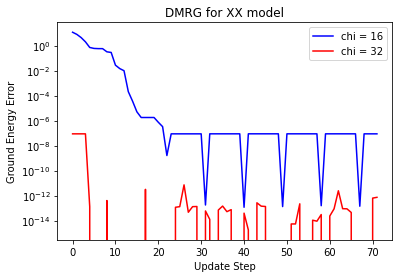

In [ ]:
# -*- coding: utf-8 -*-
"""
mainDMRG_MPO.py
---------------------------------------------------------------------
Script file for initializing the Hamiltonian of a 1D spin chain as an MPO \
before passing to the DMRG routine.

    by Glen Evenbly (c) for www.tensors.net, (v1.1) - last modified 19/1/2019
"""

##### Example 1: XX model #############
#######################################

##### Set bond dimensions and simulation options
chi = 16;
Nsites = 10;

OPTS_numsweeps = 4 # number of DMRG sweeps
OPTS_dispon = 1 # level of output display
OPTS_updateon = True # level of output display
OPTS_maxit = 2 # iterations of Lanczos method
OPTS_krydim = 4 # dimension of Krylov subspace

#### Define Hamiltonian MPO (quantum XX model)
chid = 2
sP = np.sqrt(2)*np.array([[0, 0],[1, 0]])
sM = np.sqrt(2)*np.array([[0, 1],[0, 0]])
sX = np.array([[0, 1], [1, 0]])
sY = np.array([[0, -1j], [1j, 0]])
sZ = np.array([[1, 0], [0,-1]])
sI = np.array([[1, 0], [0, 1]])
M = np.zeros([4,4,chid,chid]);
M[0,0,:,:] = sI; M[3,3,:,:] = sI
M[0,1,:,:] = sM; M[1,3,:,:] = sP
M[0,2,:,:] = sP; M[2,3,:,:] = sM
ML = np.array([1,0,0,0]).reshape(4,1,1) #left MPO boundary
MR = np.array([0,0,0,1]).reshape(4,1,1) #right MPO boundary

#### Initialize MPS tensors
A = [0 for x in range(Nsites)]
A[0] = np.random.rand(1,chid,min(chi,chid))
for k in range(1,Nsites):
    A[k] = np.random.rand(A[k-1].shape[2],chid,min(min(chi,A[k-1].shape[2]*chid),chid**(Nsites-k-1)))

#### Do DMRG sweeps (2-site approach)
En1, A, sWeight, B = doDMRG_MPO(A,ML,M,MR,chi, numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, 
                                updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)

#### Increase bond dim and reconverge
chi = 32;
En2, A, sWeight, B = doDMRG_MPO(A,ML,M,MR,chi, numsweeps = OPTS_numsweeps, dispon = OPTS_dispon, 
                                updateon = OPTS_updateon, maxit = OPTS_maxit, krydim = OPTS_krydim)

#### Compare with exact results (computed from free fermions)
H = np.diag(np.ones(Nsites-1),k=1) + np.diag(np.ones(Nsites-1),k=-1)
D = LA.eigvalsh(H)
EnExact = 2*sum(D[D < 0])

##### Plot results
plt.figure(1)
plt.yscale('log')
plt.plot(range(len(En1)), En1 - EnExact, 'b', label="chi = 16")
plt.plot(range(len(En2)), En2 - EnExact, 'r', label="chi = 32")
plt.legend()
plt.title('DMRG for XX model')
plt.xlabel('Update Step')
plt.ylabel('Ground Energy Error')
plt.show()

#### Compute 2-site reduced density matrices, local energy profile
rhotwo = [0 for x in range(Nsites-1)]
hamloc = (np.real(np.kron(sX,sX) + np.kron(sY,sY))).reshape(2,2,2,2)
Enloc = np.zeros(Nsites-1)
for k in range(Nsites-1):
    rhotwo[k] = ncon([A[k],np.conj(A[k]),A[k+1],np.conj(A[k+1]),sWeight[k+2],
                     sWeight[k+2]],[[1,-3,2],[1,-1,3],[2,-4,4],[3,-2,5],[4,6],[5,6]])
    Enloc[k] = ncon([hamloc,rhotwo[k]],[[1,2,3,4],[1,2,3,4]])